In [1]:
import torch
from dataset import CelebMBTIMultiTargetDataset

In [2]:
# from utils import assign_splits, get_label_mapping

# assign_splits(
#     file_path="faces_yolo_metadata.csv",
#     id_column="id",
#     label_column="mbti",
# )

In [3]:
from torchvision import transforms

train_tf = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomApply([transforms.ColorJitter(0.25, 0.25, 0.25, 0.05)], p=0.8),
        transforms.RandomApply(
            [
                transforms.RandomAffine(
                    degrees=10,  # small rotation
                    translate=(0.05, 0.05),  # small shifts
                    scale=(0.9, 1.1),
                )
            ],
            p=0.5,
        ),
        transforms.RandomApply([transforms.GaussianBlur(kernel_size=3)], p=0.2),
        transforms.ToTensor(),
        transforms.RandomErasing(
            p=0.25, scale=(0.02, 0.1), ratio=(0.3, 3.3), value="random"
        ),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]
)

val_tf = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]
)

In [4]:
from torch.utils.data import DataLoader

train_ds = CelebMBTIMultiTargetDataset(
    root_dir="faces_yolo",
    metadata_csv="faces_yolo_metadata.csv",
    split="train",
    transform=train_tf,
)

val_ds = CelebMBTIMultiTargetDataset(
    root_dir="faces_yolo",
    metadata_csv="faces_yolo_metadata.csv",
    split="val",
    transform=val_tf,
)

test_ds = CelebMBTIMultiTargetDataset(
    root_dir="faces_yolo",
    metadata_csv="faces_yolo_metadata.csv",
    split="test",
    transform=val_tf,
)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_ds, batch_size=64, shuffle=False, num_workers=4)

for images, labels in train_loader:
    print(images.shape)  # [Batch, 3, 224, 224]
    print(labels.shape)  # [Batch, 4]
    break

torch.Size([32, 3, 224, 224])
torch.Size([32, 4])


In [8]:
from torchvision.models import resnet18, ResNet18_Weights
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class MBTIMultiHeadModel(nn.Module):
    def __init__(self, freeze_backbone=False):
        super().__init__()

        # 1. The Shared Backbone (ResNet18)
        # We use ResNet18 because ResNet50 is too big for 7k images (overfitting risk)
        base_model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)

        # Remove the final fully connected layer (fc)
        # Output of this sequential block will be [Batch, 512, 1, 1]
        self.backbone = nn.Sequential(*list(base_model.children())[:-1])

        if freeze_backbone:
            for param in self.backbone.parameters():
                param.requires_grad = False

        self.head_ie = self._make_head()
        self.head_ns = self._make_head()
        self.head_tf = self._make_head()
        self.head_jp = self._make_head()

    def _make_head(self):
        """
        Creates a small sub-network for a specific trait.
        Includes Dropout to fight your overfitting problem.
        """
        return nn.Sequential(
            nn.Flatten(),
            nn.Linear(512, 128),
            nn.BatchNorm1d(128),  # Helps stability
            nn.ReLU(),
            nn.Dropout(0.5),  # Critical for your small dataset
            nn.Linear(128, 1),  # Output 1 logit
        )

    def forward(self, x):
        # Extract shared features
        features = self.backbone(x)  # Shape: [Batch, 512, 1, 1]

        # Run features through each specific head
        out_ie = self.head_ie(features)
        out_ns = self.head_ns(features)
        out_tf = self.head_tf(features)
        out_jp = self.head_jp(features)

        # Concatenate them to match target shape [Batch, 4]
        # This makes it compatible with your existing loop/Loss function
        return torch.cat([out_ie, out_ns, out_tf, out_jp], dim=1)

model = MBTIMultiHeadModel(freeze_backbone=True)
model.to(device)
criterion = nn.BCEWithLogitsLoss(reduction="none")
optimizer = torch.optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3
)

In [6]:
history = {
    "train_loss_ie": [],
    "train_loss_ns": [],
    "train_loss_tf": [],
    "train_loss_jp": [],
    "val_loss_ie": [],
    "val_loss_ns": [],
    "val_loss_tf": [],
    "val_loss_jp": [],
    # We can still track global accuracy if you like
    "train_acc": [],
    "val_acc": [],
}

trait_names = ["ie", "ns", "tf", "jp"]

In [9]:
from tqdm import tqdm

for epoch in range(10):
    model.train()
    pbar = tqdm(train_loader, desc=f"Epoch {epoch:02d} [train]", leave=False)

    # Accumulators for 4 separate heads
    train_head_losses = [0.0, 0.0, 0.0, 0.0]
    train_correct_bits = 0
    train_total_bits = 0
    train_total_samples = 0

    for x, y in pbar:
        x = x.to(device)
        y = y.to(device).float()

        optimizer.zero_grad()
        logits = model(x)

        # raw_loss is shape [Batch_Size, 4]
        raw_loss = criterion(logits, y)

        loss_for_backprop = raw_loss.mean()
        loss_for_backprop.backward()
        optimizer.step()

        batch_head_losses = raw_loss.mean(dim=0)

        for i in range(4):
            # We weigh by batch size for accurate epoch averaging later
            train_head_losses[i] += batch_head_losses[i].item() * y.size(0)

        # --- Accuracy Tracking (Same as before) ---
        probs = torch.sigmoid(logits)
        preds = (probs > 0.5).float()
        train_correct_bits += (preds == y).sum().item()
        train_total_bits += y.numel()
        train_total_samples += y.size(0)

        pbar.set_postfix(loss=loss_for_backprop.item())

    # Normalize Epoch Metrics
    tr_acc = train_correct_bits / train_total_bits
    # Store per-head losses in history
    for i, name in enumerate(trait_names):
        avg_loss = train_head_losses[i] / train_total_samples
        history[f"train_loss_{name}"].append(avg_loss)

    # --- VALIDATION PHASE ---
    model.eval()
    pbar = tqdm(val_loader, desc=f"Epoch {epoch:02d} [val]", leave=False)

    val_head_losses = [0.0, 0.0, 0.0, 0.0]
    val_correct_bits = 0
    val_total_bits = 0
    val_total_samples = 0

    with torch.no_grad():
        for x, y in pbar:
            x = x.to(device)
            y = y.to(device).float()

            logits = model(x)
            raw_loss = criterion(logits, y)

            # Track Per Head
            batch_head_losses = raw_loss.mean(dim=0)
            for i in range(4):
                val_head_losses[i] += batch_head_losses[i].item() * y.size(0)

            # Track Accuracy
            probs = torch.sigmoid(logits)
            preds = (probs > 0.5).float()
            val_correct_bits += (preds == y).sum().item()
            val_total_bits += y.numel()
            val_total_samples += y.size(0)

    va_acc = val_correct_bits / val_total_bits

    # Store val history
    log_msg = []
    for i, name in enumerate(trait_names):
        avg_loss = val_head_losses[i] / val_total_samples
        history[f"val_loss_{name}"].append(avg_loss)
        log_msg.append(f"{name.upper()}:{avg_loss:.3f}")

    # Save accuracy
    history["train_acc"].append(tr_acc)
    history["val_acc"].append(va_acc)

    # Print compact summary
    print(
        f"Epoch {epoch:02d} | "
        f"Tr Acc: {tr_acc:.3f} | Va Acc: {va_acc:.3f} | "
        f"Val Losses -> {' '.join(log_msg)}"
    )

Epoch 00 | Tr Acc: 0.548 | Va Acc: 0.550 | Val Losses -> IE:0.662 NS:0.709 TF:0.681 JP:0.697


Epoch 01 | Tr Acc: 0.577 | Va Acc: 0.562 | Val Losses -> IE:0.656 NS:0.698 TF:0.678 JP:0.698


Epoch 02 | Tr Acc: 0.588 | Va Acc: 0.580 | Val Losses -> IE:0.655 NS:0.695 TF:0.674 JP:0.692


Epoch 03 | Tr Acc: 0.593 | Va Acc: 0.579 | Val Losses -> IE:0.653 NS:0.686 TF:0.675 JP:0.691


Epoch 04 | Tr Acc: 0.599 | Va Acc: 0.581 | Val Losses -> IE:0.657 NS:0.683 TF:0.670 JP:0.698


Epoch 05 | Tr Acc: 0.602 | Va Acc: 0.574 | Val Losses -> IE:0.656 NS:0.683 TF:0.677 JP:0.688


Epoch 06 | Tr Acc: 0.603 | Va Acc: 0.577 | Val Losses -> IE:0.653 NS:0.684 TF:0.674 JP:0.695


Epoch 07 | Tr Acc: 0.607 | Va Acc: 0.591 | Val Losses -> IE:0.656 NS:0.679 TF:0.668 JP:0.687


Epoch 08 | Tr Acc: 0.610 | Va Acc: 0.583 | Val Losses -> IE:0.663 NS:0.686 TF:0.667 JP:0.693


Epoch 09 | Tr Acc: 0.613 | Va Acc: 0.579 | Val Losses -> IE:0.650 NS:0.683 TF:0.666 JP:0.698


In [10]:
# unfreeze the backbone for fine-tuning
for param in model.backbone.parameters():
    param.requires_grad = True

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

for epoch in range(10):
    model.train()
    pbar = tqdm(train_loader, desc=f"Epoch {epoch:02d} [train]", leave=False)

    # Accumulators for 4 separate heads
    train_head_losses = [0.0, 0.0, 0.0, 0.0]
    train_correct_bits = 0
    train_total_bits = 0
    train_total_samples = 0

    for x, y in pbar:
        x = x.to(device)
        y = y.to(device).float()

        optimizer.zero_grad()
        logits = model(x)

        # raw_loss is shape [Batch_Size, 4]
        raw_loss = criterion(logits, y)

        # For Backprop: We still need ONE scalar.
        # We mean() over the batch AND the heads.
        loss_for_backprop = raw_loss.mean()
        loss_for_backprop.backward()
        optimizer.step()

        # --- Tracking Per Head ---
        # Average over the batch dimension (dim=0) to get [4] losses for this batch
        batch_head_losses = raw_loss.mean(dim=0)

        for i in range(4):
            # We weigh by batch size for accurate epoch averaging later
            train_head_losses[i] += batch_head_losses[i].item() * y.size(0)

        # --- Accuracy Tracking (Same as before) ---
        probs = torch.sigmoid(logits)
        preds = (probs > 0.5).float()
        train_correct_bits += (preds == y).sum().item()
        train_total_bits += y.numel()
        train_total_samples += y.size(0)

        pbar.set_postfix(loss=loss_for_backprop.item())

    # Normalize Epoch Metrics
    tr_acc = train_correct_bits / train_total_bits
    # Store per-head losses in history
    for i, name in enumerate(trait_names):
        avg_loss = train_head_losses[i] / train_total_samples
        history[f"train_loss_{name}"].append(avg_loss)

    # --- VALIDATION PHASE ---
    model.eval()
    pbar = tqdm(val_loader, desc=f"Epoch {epoch:02d} [val]", leave=False)

    val_head_losses = [0.0, 0.0, 0.0, 0.0]
    val_correct_bits = 0
    val_total_bits = 0
    val_total_samples = 0

    with torch.no_grad():
        for x, y in pbar:
            x = x.to(device)
            y = y.to(device).float()

            logits = model(x)
            raw_loss = criterion(logits, y)

            # Track Per Head
            batch_head_losses = raw_loss.mean(dim=0)
            for i in range(4):
                val_head_losses[i] += batch_head_losses[i].item() * y.size(0)

            # Track Accuracy
            probs = torch.sigmoid(logits)
            preds = (probs > 0.5).float()
            val_correct_bits += (preds == y).sum().item()
            val_total_bits += y.numel()
            val_total_samples += y.size(0)

    va_acc = val_correct_bits / val_total_bits

    # Store val history
    log_msg = []
    for i, name in enumerate(trait_names):
        avg_loss = val_head_losses[i] / val_total_samples
        history[f"val_loss_{name}"].append(avg_loss)
        log_msg.append(f"{name.upper()}:{avg_loss:.3f}")

    # Save accuracy
    history["train_acc"].append(tr_acc)
    history["val_acc"].append(va_acc)

    # Print compact summary
    print(
        f"Epoch {epoch:02d} | "
        f"Tr Acc: {tr_acc:.3f} | Va Acc: {va_acc:.3f} | "
        f"Val Losses -> {' '.join(log_msg)}"
    )

Epoch 00 | Tr Acc: 0.603 | Va Acc: 0.593 | Val Losses -> IE:0.648 NS:0.661 TF:0.670 JP:0.708


Epoch 01 | Tr Acc: 0.641 | Va Acc: 0.599 | Val Losses -> IE:0.659 NS:0.675 TF:0.674 JP:0.693


Epoch 02 | Tr Acc: 0.669 | Va Acc: 0.601 | Val Losses -> IE:0.665 NS:0.646 TF:0.692 JP:0.673


Epoch 03 | Tr Acc: 0.705 | Va Acc: 0.596 | Val Losses -> IE:0.672 NS:0.783 TF:0.711 JP:0.720


Epoch 04 | Tr Acc: 0.733 | Va Acc: 0.624 | Val Losses -> IE:0.674 NS:0.661 TF:0.703 JP:0.715


Epoch 05 | Tr Acc: 0.765 | Va Acc: 0.622 | Val Losses -> IE:0.689 NS:0.654 TF:0.714 JP:0.713


Epoch 06 | Tr Acc: 0.793 | Va Acc: 0.646 | Val Losses -> IE:0.698 NS:0.642 TF:0.698 JP:0.722


Epoch 07 | Tr Acc: 0.822 | Va Acc: 0.656 | Val Losses -> IE:0.628 NS:0.740 TF:0.673 JP:0.748


Epoch 08 | Tr Acc: 0.840 | Va Acc: 0.659 | Val Losses -> IE:0.691 NS:0.704 TF:0.718 JP:0.734


Epoch 09 | Tr Acc: 0.866 | Va Acc: 0.664 | Val Losses -> IE:0.698 NS:0.698 TF:0.749 JP:0.807


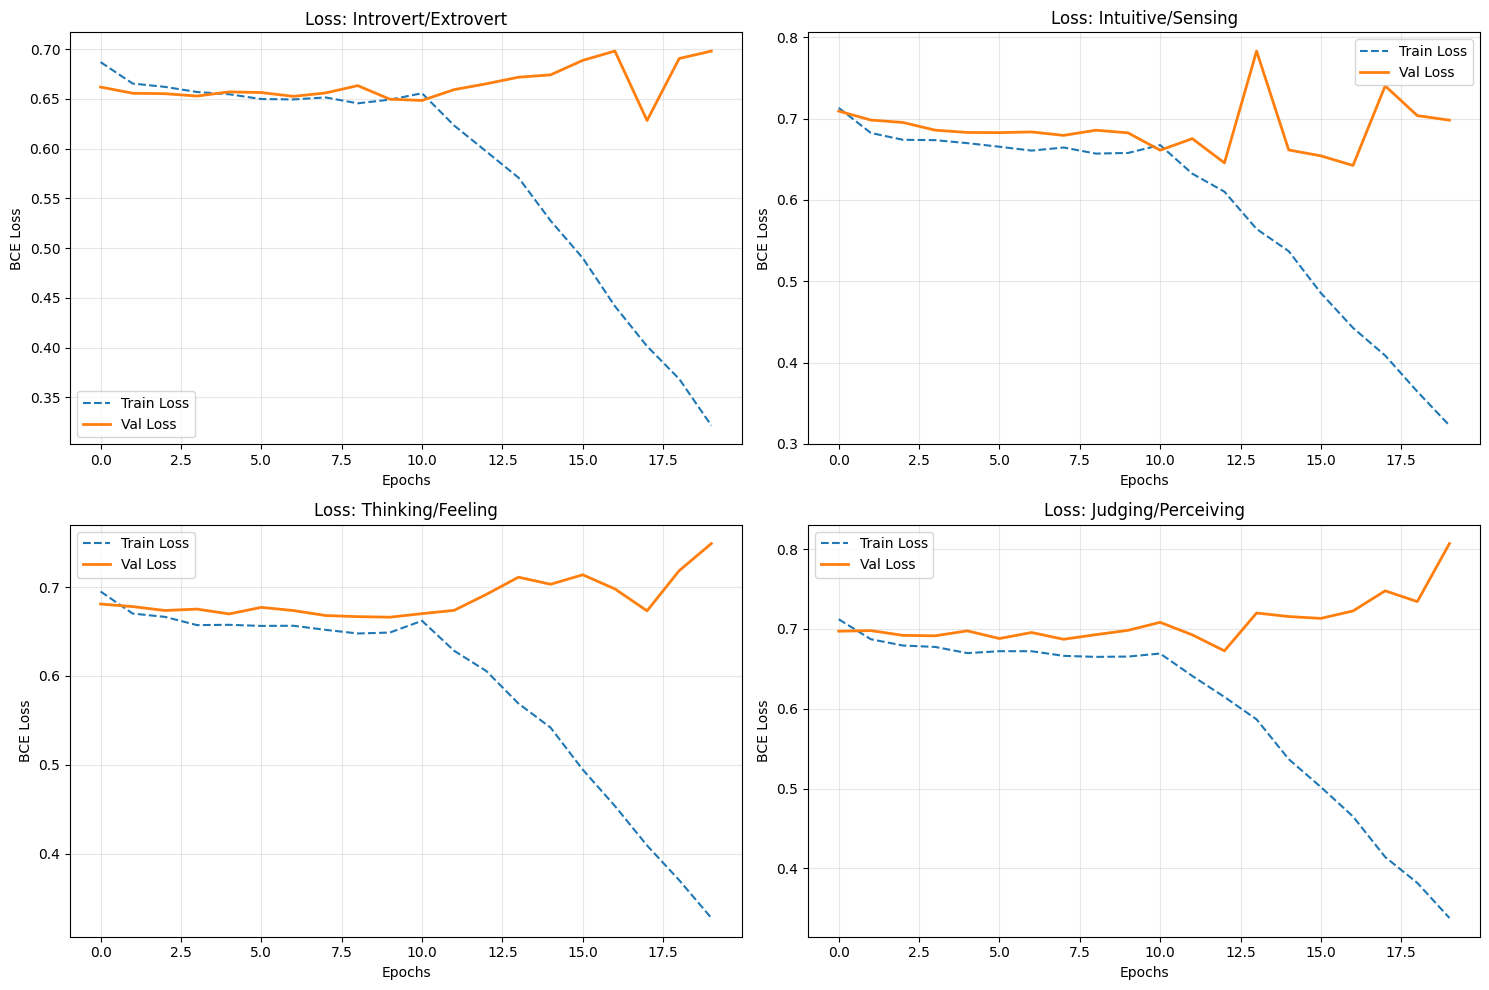

In [11]:
import matplotlib.pyplot as plt


def plot_per_head_history(history):
    epochs = range(len(history["train_acc"]))
    traits = ["ie", "ns", "tf", "jp"]
    titles = [
        "Introvert/Extrovert",
        "Intuitive/Sensing",
        "Thinking/Feeling",
        "Judging/Perceiving",
    ]

    plt.figure(figsize=(15, 10))

    for i, trait in enumerate(traits):
        plt.subplot(2, 2, i + 1)

        # Plot Train vs Val for this specific trait
        plt.plot(
            epochs, history[f"train_loss_{trait}"], label=f"Train Loss", linestyle="--"
        )
        plt.plot(epochs, history[f"val_loss_{trait}"], label=f"Val Loss", linewidth=2)

        plt.title(f"Loss: {titles[i]}")
        plt.xlabel("Epochs")
        plt.ylabel("BCE Loss")
        plt.legend()
        plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()


# Call it after training
plot_per_head_history(history)

In [ ]:
from sklearn.metrics import roc_auc_score
import numpy as np

# Add to history
history["val_auc_ie"] = []
history["val_auc_ns"] = []
history["val_auc_tf"] = []
history["val_auc_jp"] = []

# --- VALIDATION PHASE ---
model.eval()
pbar = tqdm(val_loader, desc=f"Epoch {epoch:02d} [val]", leave=False)

# Containers to hold the ENTIRE validation set's data
all_val_targets = []
all_val_probs = []

val_head_losses = [0.0, 0.0, 0.0, 0.0]
val_total_samples = 0

with torch.no_grad():
    for x, y in pbar:
        x = x.to(device)
        y = y.to(device).float()

        logits = model(x)

        # Calculate Loss as before
        raw_loss = criterion(logits, y)
        batch_head_losses = raw_loss.mean(dim=0)
        for i in range(4):
            val_head_losses[i] += batch_head_losses[i].item() * y.size(0)

        val_total_samples += y.size(0)

        # --- STORE PREDICTIONS FOR AUC ---
        probs = torch.sigmoid(logits)

        # Move to CPU and store in list
        all_val_targets.append(y.cpu())
        all_val_probs.append(probs.cpu())

val_targets_np = torch.cat(all_val_targets).numpy()
val_probs_np = torch.cat(all_val_probs).numpy()

aucs = []
trait_names = ["ie", "ns", "tf", "jp"]

for i in range(4):
    # Extract column i
    true_col = val_targets_np[:, i]
    prob_col = val_probs_np[:, i]

    try:
        # roc_auc_score requires valid data (must have at least one 0 and one 1 in targets)
        score = roc_auc_score(true_col, prob_col)
    except ValueError:
        # Takes care of edge case where a batch might only have 1 class
        score = 0.5

    aucs.append(score)
    history[f"val_auc_{trait_names[i]}"].append(score)

# 3. Logging
print(
    f"Epoch {epoch:02d} | "
    f"Losses: {val_head_losses[0]/val_total_samples:.3f} "
    f"{val_head_losses[1]/val_total_samples:.3f} ... | "
    f"AUCs -> IE:{aucs[0]:.3f} NS:{aucs[1]:.3f} TF:{aucs[2]:.3f} JP:{aucs[3]:.3f}"
)

Epoch 09 | Losses: 0.698 0.698 ... | AUCs -> IE:0.735 NS:0.725 TF:0.707 JP:0.699
